# Capstone Project - Energy Consumption
The project aims to leverage machine learning techniques to
build an RNN-based model to predict energy consumption and identify trends in the
dataset.

The dataset comprises hourly MW energy consumption data from AEP energy who services over 10 different states across the US.

### Notebook Setup
Importing the required libraries:

In [2]:
# Core libraries for data manipulation and numerical computations
import pandas as pd
import numpy as np

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for machine learning and neural network modeling
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Scikit-learn for preprocessing and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Statsmodels for time series decomposition (if needed)
import statsmodels.api as sm


### Load the Data

In [3]:
data = pd.read_csv('AEP_hourly.csv')
data.head()

,Datetime,AEP_MW
0,10/1/2004 1:00,12379
1,10/1/2004 2:00,11935
2,10/1/2004 3:00,11692
3,10/1/2004 4:00,11597
4,10/1/2004 5:00,11681


### Preprocess Data
Convert Datetime to datetime:

In [4]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)


Extract time-based features:

In [5]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month


Add holidays

In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=data.index.min(), end=data.index.max())
data['is_holiday'] = data.index.isin(holidays)


Check for missing values:

In [7]:
data.isnull().sum()
data.ffill(inplace=True)

Visualize the data

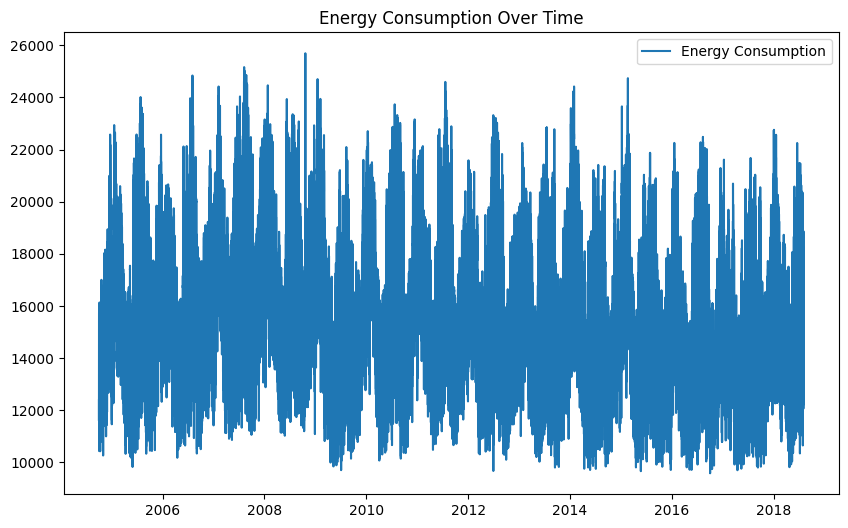

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data['AEP_MW'], label='Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()

### Prepare Data for RNN

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['AEP_MW'] = scaler.fit_transform(data[['AEP_MW']])

def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24
X, y = create_sequences(data['AEP_MW'].values, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Build and Train the Model

Epoch 1/20
2425/2425 [==============================] - 34s 13ms/step - loss: 0.0036 - mae: 0.0383 - val_loss: 3.3562e-04 - val_mae: 0.0134
Epoch 2/20
2425/2425 [==============================] - 30s 13ms/step - loss: 3.8222e-04 - mae: 0.0147 - val_loss: 3.0274e-04 - val_mae: 0.0126
Epoch 3/20
2425/2425 [==============================] - 30s 12ms/step - loss: 3.1486e-04 - mae: 0.0134 - val_loss: 2.2277e-04 - val_mae: 0.0109
Epoch 4/20
2425/2425 [==============================] - 32s 13ms/step - loss: 2.8031e-04 - mae: 0.0126 - val_loss: 0.0013 - val_mae: 0.0256
Epoch 5/20
2425/2425 [==============================] - 32s 13ms/step - loss: 2.6524e-04 - mae: 0.0122 - val_loss: 2.3933e-04 - val_mae: 0.0122
Epoch 6/20
2425/2425 [==============================] - 31s 13ms/step - loss: 2.3314e-04 - mae: 0.0114 - val_loss: 1.6809e-04 - val_mae: 0.0098
Epoch 7/20
2425/2425 [==============================] - 32s 13ms/step - loss: 2.1610e-04 - mae: 0.0110 - val_loss: 2.5258e-04 - val_mae: 0.0126


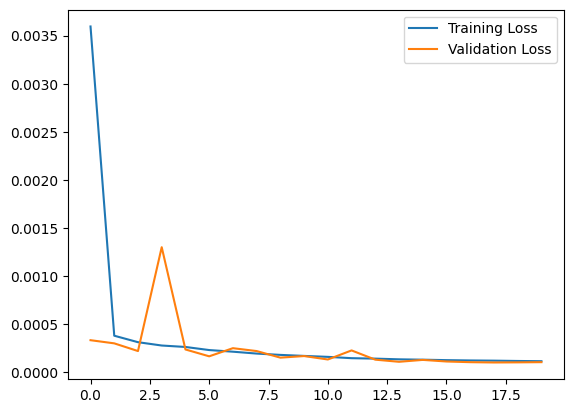

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Evaluate the Model

In [11]:
# Predict and rescale outputs
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)


758/758 [==============================] - 4s 4ms/step


In [12]:
# Calculate evaluation metrics based on Root Mean Squared Error and the Mean Absolute Error
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse}, MAE: {mae}')


RMSE: 173.34940274421243, MAE: 127.23216289465206


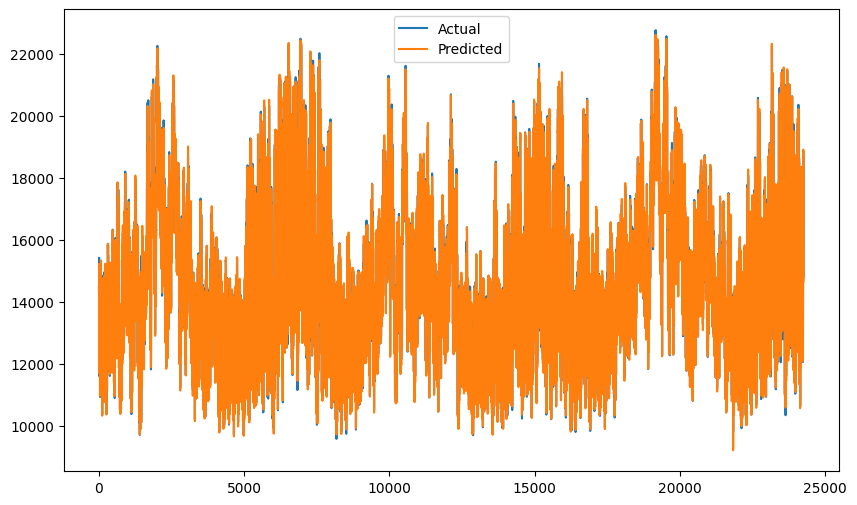

In [13]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


### Analyze Trends

In [14]:
# Group by hour/day/month for trends:
hourly_trends = data.groupby('hour')['AEP_MW'].mean()
daily_trends = data.groupby('day_of_week')['AEP_MW'].mean()
monthly_trends = data.groupby('month')['AEP_MW'].mean()

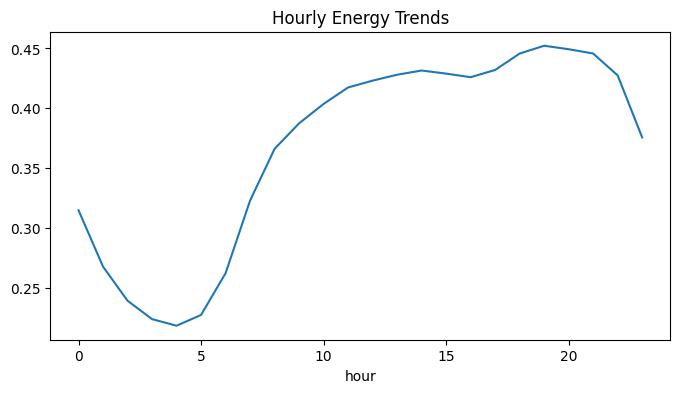

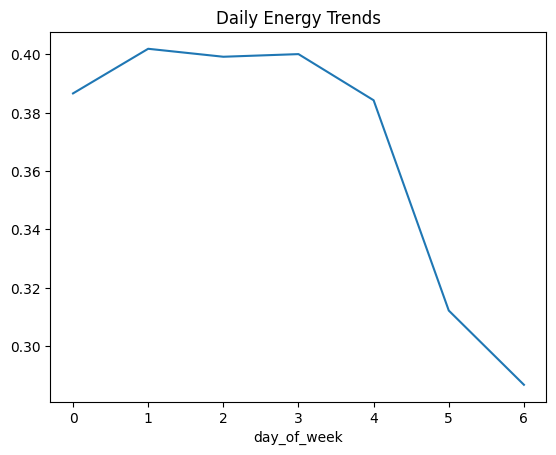

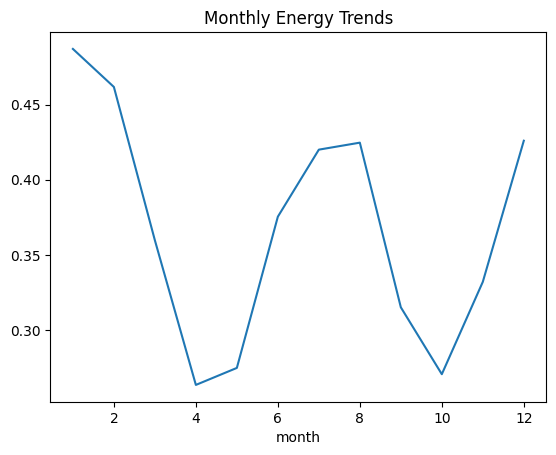

In [15]:
# Visualize trends:
plt.figure(figsize=(8, 4))
hourly_trends.plot(title='Hourly Energy Trends')
plt.show()

daily_trends.plot(title='Daily Energy Trends')
plt.show()

monthly_trends.plot(title='Monthly Energy Trends')
plt.show()


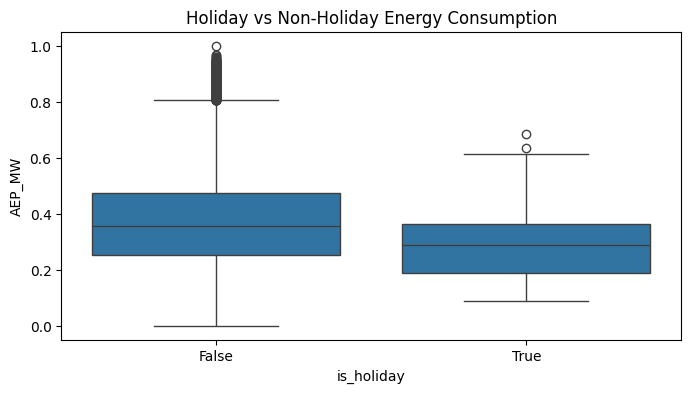

In [16]:
# Analyze holiday effects:
holiday_data = data[data['is_holiday'] == True]
non_holiday_data = data[data['is_holiday'] == False]

plt.figure(figsize=(8, 4))
sns.boxplot(x=data['is_holiday'], y=data['AEP_MW'])
plt.title('Holiday vs Non-Holiday Energy Consumption')
plt.show()

### Summary
The model demonstrated strong learning capability, effectively capturing key energy consumption trends. It identified that consumption tends to rise significantly on weekdays and drops sharply on weekends. Energy usage peaks during the daytime hours, which aligns with the active periods when most people are awake. The analysis revealed that the highest energy consumption months are January, July, August, and December, with January recording the all-time peak. Additionally, non-holiday days exhibited higher overall energy usage but with greater variability, whereas holidays generally showed lower energy consumption accompanied by reduced variance.

Energy consumption also closely aligned with temperatures. The lowest energy consumption times were recorded in both the middle of spring and the middle of fall, with both seasons averaging temperatures in the 60s-80s.

## Model Evolution
### Autoencoders for Anomaly Detection
After learning about autoencoders in ML class, I applied it to this model.

In [17]:
# Assuming `data['AEP_MW']` is already normalized
energy_data = data['AEP_MW'].values.reshape(-1, 1)

train_data, test_data = train_test_split(energy_data, test_size=0.2, shuffle=False)


### Build and Train the Autoencoder Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 16)                32        
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3032/3032 [=========

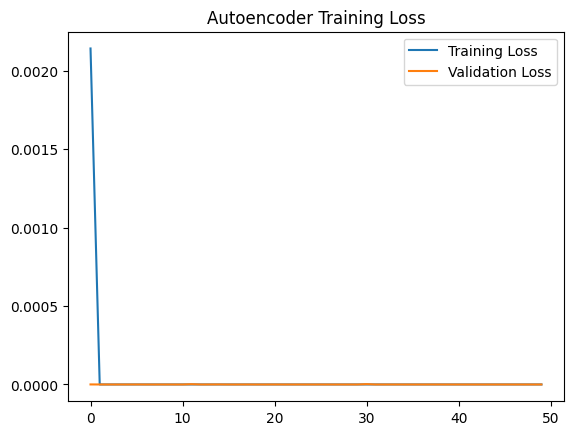

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Input layer
input_layer = Input(shape=(1,))

# Encoder
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(1, activation='linear')(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Training
history = autoencoder.fit(
    train_data, train_data,
    epochs=50,
    batch_size=32,
    validation_data=(test_data, test_data),
    shuffle=True
)

# Plotting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

### Anomaly Detection

In [19]:
# Reconstruct the test data
test_predictions = autoencoder.predict(test_data)

# Calculate reconstruction errors
reconstruction_errors = np.abs(test_data - test_predictions)

threshold = np.percentile(reconstruction_errors, 95)  # 95th percentile
print(f"Anomaly Threshold: {threshold}")

anomalies = reconstruction_errors > threshold
print(f"Number of Anomalies Detected: {np.sum(anomalies)}")


758/758 [==============================] - 0s 590us/step
Anomaly Threshold: 0.00016781066870208416
Number of Anomalies Detected: 1212


### Visualize Anomalies


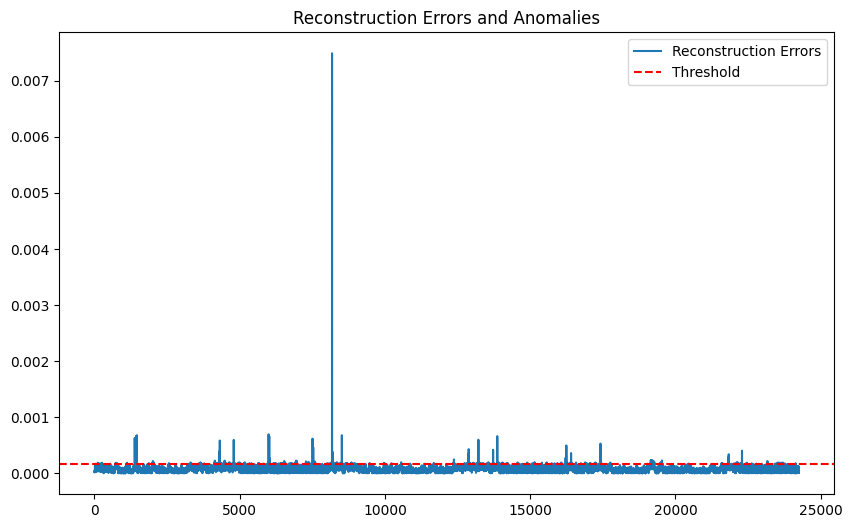

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors, label='Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('Reconstruction Errors and Anomalies')
plt.show()


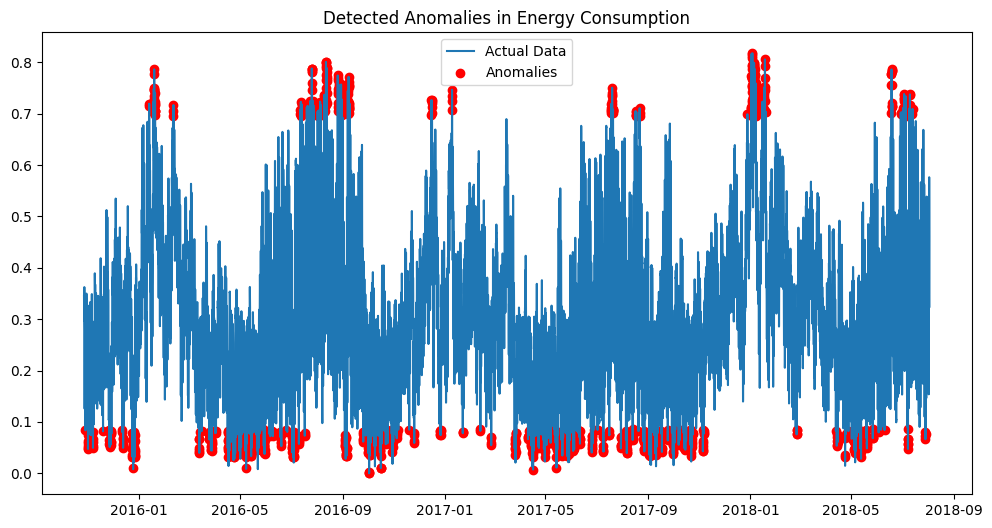

In [21]:
# Ensure test_data is correctly shaped for plotting
test_data_series = pd.Series(test_data.squeeze(), index=data.index[-len(test_data):])

# Plot the actual data
plt.figure(figsize=(12, 6))
plt.plot(test_data_series.index, test_data_series, label='Actual Data')

# Plot anomalies
plt.scatter(
    test_data_series.index[anomalies.squeeze()],  # Use index for anomalies
    test_data_series[anomalies.squeeze()],       # Use values for anomalies
    color='red',
    label='Anomalies'
)

plt.legend()
plt.title('Detected Anomalies in Energy Consumption')
plt.show()


## Final Summary
The detected anomalies in energy consumption reveal critical insights into irregular patterns and potential underlying causes. Sudden drops may indicate power outages, equipment failuresas, industrial activities or extreme weather events. Holidays and public events often lead to deviations from typical trends, reflecting behavioral shifts in energy use. Additionally, anomalies may highlight data quality issues, such as measurement errors or gaps in recording.

Overall the model performed exceptionally well and was able to predict energy consumption patterns with great accuracy. Using autoencoders, the model was also able to detect anomalies without specifying the thresholds. 